<a href="https://colab.research.google.com/github/velozo27/TCC-Pedro-Velozo-ENG1132/blob/change-how-image-files-are-retrieved/SRCNN_Comentada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports e definição de Constantes

In [1]:
try:
    from google.colab import files
    from google.colab import drive
    drive.mount("/content/gdrive")
    DATASET_ROOT="/content/gdrive/MyDrive/TCC/datasets"
    !pip install patchify
    # wandb to log system metrics: (check CPU and GPU usage while session is runnig)
    !pip install wandb
    import wandb
    wandb.init()
    
    import save_model_helper

except ModuleNotFoundError:
    DATASET_ROOT="./datasets/"
    # coloquei as dependencias em um arquivo separado
    !pip install -r requirements.txt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.io import read_image
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
from datetime import datetime
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torchvision.transforms import Compose, ToTensor, Resize
import pandas as pd
import time
import re
from pathlib import Path
import image_patches
import image_helper
import load_model_helper


DATASET_NAME = "Flickr2K"
# DATASET_NAME = "Set14"

# Mudar aqui se for para treinar salvando os dataframes e epochs no drive
# Se True, não pega nem salva nada no drive
EXPERIMENTAL_MODE = True


# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
# garantir que é cuda
assert device == "cuda"

# https://stackoverflow.com/questions/65734044/kernel-appears-to-have-died-jupyter-notebook-python-matplotlib
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Criando os patches

(patches já foram criados, não precisa rodar)

In [2]:
%time
# otimizacao: criar patches de treino, validacao e teste de uma vez: (32, 8, 2)
# image_patches.create_image_patches(f"{DATASET_ROOT}/{DATASET_NAME}", (33, 33, 3), f"{DATASET_ROOT}/{DATASET_NAME}_train", 32)
# image_patches.create_image_patches(f"{DATASET_ROOT}/{DATASET_NAME}", (33, 33, 3), f"{DATASET_ROOT}/{DATASET_NAME}_validation", 8)

CPU times: total: 0 ns
Wall time: 0 ns


# ***SRCNN***

In [3]:
class SRCNN(nn.Module):
    def __init__(self, initialization="normal") -> None:
        super(SRCNN, self).__init__()
        # 4.3 Model and Performance Trade-offs
        # Based on the basic network settings (i.e., f1 = 9, f2 = 1, f3 = 5, n1 = 64, and n2 = 32),
        f1 = 9
        f2 = 1
        f3 = 5
        n1 = 64
        # n1 = 3
        n2 = 32

        self.initialization = initialization

        self.model = nn.Sequential(
            # 3.1.1 Patch extraction and representation
            nn.Conv2d(in_channels=3, out_channels=n1,
#                       kernel_size=(f1, f1), padding=(f1-1)//2), # TODO: ver como ficar sem o padding
                      kernel_size=(f1, f1), padding=0,),
            nn.ReLU(),

            # # 3.1.2 Non-linear mapping
            nn.Conv2d(in_channels=n1, out_channels=n2,
                      # kernel_size=(f2, f2), padding=(f2-1)//2),
                      kernel_size=(f2, f2), padding=0,),
            nn.ReLU(),

#             # # 3.1.3 Reconstruction
            nn.Conv2d(in_channels=n2, out_channels=3,
#                       kernel_size=(f3, f3), padding=(f3-1)//2),
                      kernel_size=(f3, f3), padding=0),
        )

        self._init_weights()

    def _init_weights(self):
      # The filter weights of each layer are initialized by drawing randomly 
      # from a Gaussian distribution with zero mean and standard deviation 0.001 (and 0 for biases)
      for module in self.modules():
        if isinstance(module, nn.Conv2d):
          if self.initialization == "normal":
            module.weight.data.normal_(mean=0.0, std=0.001)
          elif self.initialization == "xavier":
            nn.init.xavier_normal_(module.weight.data)
          else:
            nn.init.eye_(module.weight.data)

          if module.bias is not None:
              module.bias.data.zero_()

    def print_weights(self):
      for module in self.modules():
       if isinstance(module, nn.Conv2d):
          print(module.weight)

    def forward(self, x: torch.Tensor):
        x = self.model(x)
        return x


In [4]:
model_test = SRCNN()

input_1 = torch.randn([3, 33, 33])
print(input_1.shape)

output_1 = model_test(input_1)
print(output_1.shape)

torch.Size([3, 33, 33])
torch.Size([3, 21, 21])


# Loops de **Treino** e **Validação**

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer, device="cuda" if torch.cuda.is_available() else "cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    print(f"Training on {size} samples...")
    print("Batch size:", dataloader.batch_size)
    print("Number of batches:", num_batches)

    train_loss = 0
    for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = X.to(device)
        #print("X", X.shape, X.get_device())
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss /= num_batches

    # return avg loss
    print(f"Training Error: \n Avg loss: {train_loss:>8f} \n")
    return train_loss

# will also be used for testing (maybe)
def validation_loop(dataloader, model, loss_fn, device="cuda" if torch.cuda.is_available() else "cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    validation_loss = 0

    with torch.no_grad(), tqdm(total=num_batches) as progress_bar:
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            validation_loss += loss_fn(pred, y).item()
            progress_bar.update(1)

    validation_loss /= num_batches

    print(f"Validation Error: \n Avg loss: {validation_loss:>8f} \n")
    return validation_loss


# CustomImageDataset

In [6]:
class CustomImageDataset(Dataset):
    """
    A PyTorch dataset for loading a directory of images.

    Args:
        img_dir (str): The path to the directory containing the images.
        transform (callable, optional): A function/transform that takes in an image and returns a
            transformed version. Default: None.
        target_transform (callable, optional): A function/transform that takes in the target and
            transforms it. Default: None.
    """

    def __init__(self, img_dir: str, patches_per_image = None | int, transform = None, target_transform = None, use_patches = True, device="cuda" if torch.cuda.is_available() else "cpu" ):
        """
        Initializes a new instance of the CustomImageDataset class.

        Args:
            img_dir (str): The path to the directory containing the images.
            transform (callable, optional): A function/transform that takes in an image and returns a
                transformed version. Default: None.
            target_transform (callable, optional): A function/transform that takes in the target and
                transforms it. Default: None.
        """
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.patches_per_image = patches_per_image
        
        self.file_list_tensor = self.create_tensors_from_images()
        self.file_list_tensor.to(device)

    def create_tensors_from_images(self):
      number_of_images = self._get_number_of_images_in_folder(f"{self.img_dir}/patches")

      # creating the empty tensor
      image_tensors = torch.empty((number_of_images, 3, 33, 33))

      current_tensor_index = 0

      all_patches_dir = f"{self.img_dir}/patches"
      if not os.path.exists(all_patches_dir) or not os.path.isdir(all_patches_dir):
          return list(os.listdir(self.img_dir))

      for patch_path in tqdm(list(os.listdir(all_patches_dir))):
        one_patch_full_dir = f"{all_patches_dir}/{patch_path}"
        one_path_relative_dir = f"patches/{patch_path}"
        
        patches_list = list(os.listdir(one_patch_full_dir))
        
        for index, patch in enumerate(patches_list):
          image_path = f"{one_path_relative_dir}/{patch}"

          if self._check_if_image_is_not_corrupted(image_path):
            continue
          
          image_as_tensor = read_image(f"{self.img_dir}/{image_path}")

          # updating the created tensor
          image_tensors[current_tensor_index] = image_as_tensor.float() / 255

          current_tensor_index += 1
                    
      return image_tensors


    def __len__(self) -> int:
        """
        Returns the number of images in the dataset.

        Returns:
            The number of images in the dataset.
        """
        return self._get_number_of_images_in_folder(f"{self.img_dir}/patches")

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Returns the image at the specified index in the dataset.

        Args:
            idx (int): The index of the image to return.

        Returns:
            A tuple containing the transformed input image and the transformed target image.
        """
    
        image = self.file_list_tensor[idx]
        image_x = image.detach().clone()
        image_y = image.detach().clone()

        if self.transform:
            image_x = self.transform(image_x)
        if self.target_transform:
            image_y = self.target_transform(image_y)

        return image_x, image_y

    def _get_number_of_images_in_folder(self, dir: str):
      """
      Gets the total number of all the patches
      """
      all_patches_dir = f"{self.img_dir}/patches"
      if not os.path.exists(all_patches_dir) or not os.path.isdir(all_patches_dir):
          return list(os.listdir(self.img_dir))

      number_of_images = 0
      for patch_path in list(os.listdir(all_patches_dir)):
        one_patch_full_dir = f"{all_patches_dir}/{patch_path}"
        one_path_relative_dir = f"patches/{patch_path}"
        
        patches_list = list(os.listdir(one_patch_full_dir))
        
        for index, patch in enumerate(patches_list):
          image_path = f"{one_path_relative_dir}/{patch}"

          if self._check_if_image_is_not_corrupted(image_path):
            continue

          number_of_images += 1

      return number_of_images

    def _check_if_image_is_not_corrupted(self, image_path: str) -> bool:
      """
      Returns True if the file is corrupted else returns False
      """
      file_size = Path(f"{self.img_dir}/{image_path}").stat().st_size

      if file_size == 0:
        print(f"Error loading image file: {self.img_dir}/{image_path}. Reason: file has size 0")
        return True
      
      return False

# Criando os ***Dataset*'s**

In [7]:
%%time
transform_x = transforms.Compose([
    # downscale by factor of 3 (from 33x33 to 11x11 back to 33x33)
    # resize image to 11x11 and downsample by BICUBIC interpolation
#     transforms.Resize((11, 11), interpolation=Image.BICUBIC),
    # resize image to 33x33
#     transforms.Resize((33, 33), interpolation=Image.BICUBIC)
#     transforms.CenterCrop((33, 33))
])

transform_y = transforms.Compose([
    ##transforms.Resize((33, 33), interpolation=Image.BICUBIC)
    transforms.CenterCrop((21, 21))
    # transforms.CenterCrop((25, 25))
#     transforms.CenterCrop((33, 33))
])

# Set up the data loaders
train_data_set = CustomImageDataset(
    img_dir=f"{DATASET_ROOT}/{DATASET_NAME}_train", transform=transform_x, target_transform=transform_y)
validation_data_set = CustomImageDataset(
    img_dir=f"{DATASET_ROOT}/{DATASET_NAME}_validation", transform=transform_x, target_transform=transform_y)

# # Report split sizes
print('Training set has {} instances'.format(len(train_data_set)))
print('Validation set has {} instances'.format(len(validation_data_set)))

100%|█████████████████████████████████████████████████████████████████████████████| 2650/2650 [00:13<00:00, 192.42it/s]


Training set has 84800 instances
Validation set has 21200 instances
CPU times: total: 11.2 s
Wall time: 1min 36s


In [24]:
%%time

# https://towardsdatascience.com/7-tips-for-squeezing-maximum-performance-from-pytorch-ca4a40951259
pin_memory = True
batch_size = round((2**12))

train_dataloader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True, pin_memory=pin_memory) # TODO: aumentar batch_size p/ 2^12
validation_dataloader = DataLoader(validation_data_set, batch_size=batch_size, pin_memory=pin_memory)

CPU times: total: 10.2 s
Wall time: 13.5 s


# Instanciando o modelo

In [25]:
# Instancianting the model
# Atencao: cuidado ao rodar o treino várias vezes sem resetar o modelo!
model = SRCNN(initialization="normal")
model.to(device)

# hyperparameters
#https://stackoverflow.com/questions/48324152/pytorch-how-to-change-the-learning-rate-of-an-optimizer-at-any-given-moment-no
lr = 1e-3

In [26]:
img = image_patches.get_image_patch(f"{DATASET_ROOT}/{DATASET_NAME}_train").float()/255
print(type(img), img.shape, img.dtype, img.min(), img.max())
with torch.no_grad():
  img_out = model(img.unsqueeze(0).to(device))
print(type(img_out), img_out.shape, img_out.dtype, img_out.min(), img_out.max())
# plt.figure()
# plt.subplot(1, 2, 1)
# plt.imshow(ImageHelperInstance.tensor_as_image(img.cpu()))
# plt.subplot(1, 2, 2)
# plt.imshow(ImageHelperInstance.tensor_as_image(img_out.squeeze().cpu()))
# plt.show()

./datasets//Flickr2K_train\patches
./datasets//Flickr2K_train\patches\002061_patch
<class 'torch.Tensor'> torch.Size([3, 33, 33]) torch.float32 tensor(0.0627) tensor(0.7647)
<class 'torch.Tensor'> torch.Size([1, 3, 21, 21]) torch.float32 tensor(-9.9364e-07, device='cuda:0') tensor(2.8547e-07, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


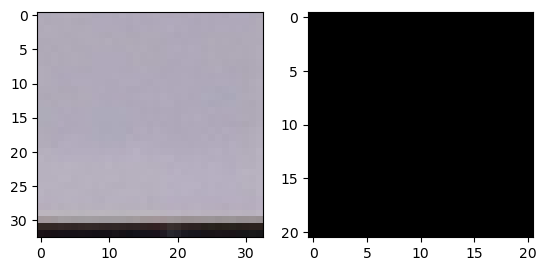

In [27]:
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(image_helper.tensor_as_image(img.cpu()))
plt.subplot(1, 2, 2)
plt.imshow(image_helper.tensor_as_image(img_out.squeeze().cpu()))
plt.show()

# Criando o *Optmizer* e a *loss function* (MSE)

In [28]:
# otimizacao: Mudar o otimizador para Adam ou RMSProp
#           : Usar momentum = 0.9
#           : Usar learning maior: 1e-4?
#           : Usar learning rate decay

# 3.3 Training
# The loss is minimized using stochastic gradient descent with the standard backpropagation
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# we use Mean Squared Error (MSE) as the loss function:
loss_fn = nn.MSELoss()
loss_fn.to(device)

MSELoss()

# Exemplos de imagem de baixa e alta resolução do dataset de treino

<class 'torch.Tensor'> torch.Size([4096, 3, 33, 33]) torch.float32 tensor(0.) tensor(1.)
<class 'torch.Tensor'> torch.Size([4096, 3, 21, 21]) torch.float32 tensor(0.) tensor(1.)
<class 'torch.Tensor'> torch.Size([4096, 3, 33, 33]) torch.float32 tensor(0.) tensor(1.)
<class 'torch.Tensor'> torch.Size([4096, 3, 21, 21]) torch.float32 tensor(0.) tensor(1.)


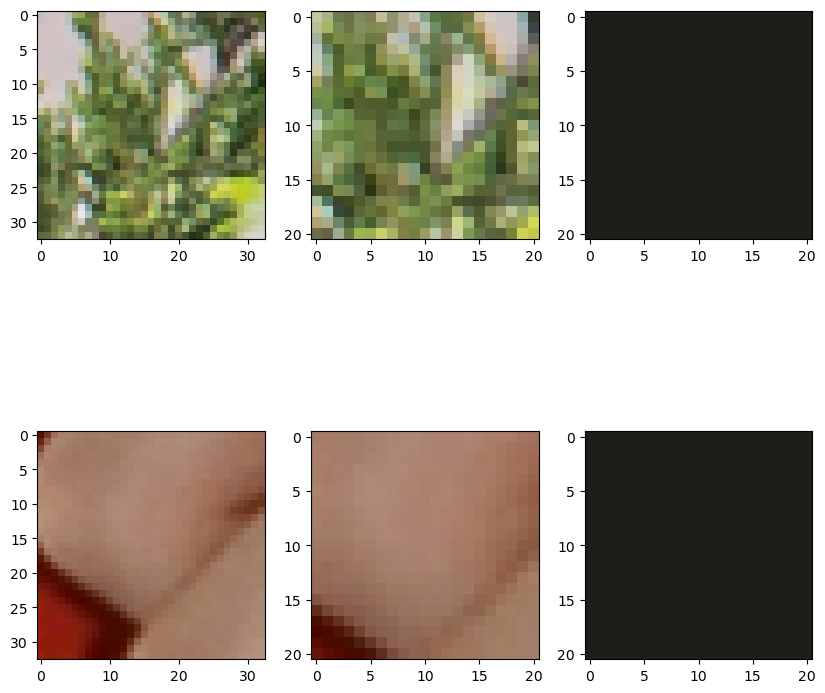

In [37]:
# example of training image
num_samples = 2
fig, axes = plt.subplots(num_samples, 3, figsize=(10, 10))
for i, (X, y) in enumerate(train_dataloader):
    with torch.no_grad():
        z = model.forward(X.to(device))
    print(type(X), X.shape, X.dtype, X.min(), X.max())
    print(type(y), y.shape, y.dtype, y.min(), y.max())
    axes[i, 0].imshow(image_helper.tensor_as_image(X[0]))
    axes[i, 1].imshow(image_helper.tensor_as_image(y[0]))
    axes[i, 2].imshow(image_helper.tensor_as_image(z[0].cpu()))
    # axes[i, 0].set_axis_off()
    if i == num_samples - 1:
        break
plt.show()

# Carregando o modelo

## Carregando a última *epoch* executada

In [30]:
# most_recent_epoch, model_load_path_name = load_model_helper.get_most_recent_epoch(directory = '/content/gdrive/My Drive/TCC/code/models/SRCNN/testing/train_session_testing/models')

# print("Most recent epoch:", most_recent_epoch)
# print("Model load path name:", model_load_path_name)

model_load_path_name = ''

In [31]:
# model = load_model_helper.load_state_dict(model, model_load_path_name)

# **Treinamento** 

## Execução das *epochs*
- Execução dos loops de treinamento e validação, e também salvamentos dos dados

In [32]:
starting_epoch = load_model_helper.get_epoch_number_from_path(model_load_path_name)
if starting_epoch is not None:
  starting_epoch = starting_epoch + 1 # add 1 because we are starting after the epoch we left of

print('starting_epoch =', starting_epoch)

starting_epoch = None


In [33]:
%%time
train_loss = 0
validation_loss = 0
epochs = 70

######
epoch_array = []
time_array = []
lr_array = []
######

# melhor usar lista e depois converter para array
train_loss_array = list()
validation_loss_array = list()
for index, t in enumerate(range(epochs)):
    current_epoch = load_model_helper.get_current_epoch(index, t, starting_epoch)
    
    print(f"\nepoch {current_epoch}\n-------------------------------")

    start_time = time.time()  # Start timing the epoch

    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    validation_loss = validation_loop(validation_dataloader, model, loss_fn)
    
    train_loss_array.append(train_loss)
    validation_loss_array.append(validation_loss)

    elapsed_time = time.time() - start_time  # Calculate elapsed time for the epoch
    
    ######
    epoch_array.append(current_epoch)
    time_array.append(elapsed_time)
    lr_array.append(optimizer.param_groups[0]['lr'])
    ######
    
    # updating learning rate
    if current_epoch % 10 == 0 and current_epoch > 0:
        optimizer.param_groups[0]['lr'] /= 2

    if not EXPERIMENTAL_MODE:
      df_path = '/content/gdrive/My Drive/TCC/code/models/SRCNN/testing/train_session_testing/SRCNN_train_vs_validation_loss.csv'
      save_model_helper.save_df(df_path, train_loss, validation_loss, current_epoch, elapsed_time)
      save_model_helper.save_epoch(current_epoch, train_loss, validation_loss)
    
print("Done!")


epoch 0
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:50<00:00,  2.40s/it]


Training Error: 
 Avg loss: 0.269429 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.05it/s]


Validation Error: 
 Avg loss: 0.269416 


epoch 1
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.44s/it]


Training Error: 
 Avg loss: 0.264188 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.31it/s]


Validation Error: 
 Avg loss: 0.264092 


epoch 2
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:49<00:00,  5.23s/it]


Training Error: 
 Avg loss: 0.258998 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.44it/s]


Validation Error: 
 Avg loss: 0.258913 


epoch 3
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:29<00:00,  1.40s/it]


Training Error: 
 Avg loss: 0.253937 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.39it/s]


Validation Error: 
 Avg loss: 0.253877 


epoch 4
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:29<00:00,  1.41s/it]


Training Error: 
 Avg loss: 0.248870 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.44it/s]


Validation Error: 
 Avg loss: 0.248981 


epoch 5
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.45s/it]


Training Error: 
 Avg loss: 0.244124 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.37it/s]


Validation Error: 
 Avg loss: 0.244219 


epoch 6
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.46s/it]


Training Error: 
 Avg loss: 0.239547 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.12it/s]


Validation Error: 
 Avg loss: 0.239586 


epoch 7
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.44s/it]


Training Error: 
 Avg loss: 0.235067 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.40it/s]


Validation Error: 
 Avg loss: 0.235080 


epoch 8
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.43s/it]


Training Error: 
 Avg loss: 0.230652 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.40it/s]


Validation Error: 
 Avg loss: 0.230698 


epoch 9
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.43s/it]


Training Error: 
 Avg loss: 0.226203 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.41it/s]


Validation Error: 
 Avg loss: 0.226438 


epoch 10
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:34<00:00,  1.65s/it]


Training Error: 
 Avg loss: 0.222104 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.40it/s]


Validation Error: 
 Avg loss: 0.222295 


epoch 11
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:32<00:00,  1.56s/it]


Training Error: 
 Avg loss: 0.219054 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.40it/s]


Validation Error: 
 Avg loss: 0.220266 


epoch 12
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:29<00:00,  1.41s/it]


Training Error: 
 Avg loss: 0.216983 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.33it/s]


Validation Error: 
 Avg loss: 0.218265 


epoch 13
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.44s/it]


Training Error: 
 Avg loss: 0.215004 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.37it/s]


Validation Error: 
 Avg loss: 0.216292 


epoch 14
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:31<00:00,  1.51s/it]


Training Error: 
 Avg loss: 0.213124 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.35it/s]


Validation Error: 
 Avg loss: 0.214347 


epoch 15
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.47s/it]


Training Error: 
 Avg loss: 0.211232 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.35it/s]


Validation Error: 
 Avg loss: 0.212428 


epoch 16
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:29<00:00,  1.43s/it]


Training Error: 
 Avg loss: 0.209249 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.35it/s]


Validation Error: 
 Avg loss: 0.210536 


epoch 17
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.44s/it]


Training Error: 
 Avg loss: 0.207442 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.40it/s]


Validation Error: 
 Avg loss: 0.208669 


epoch 18
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.44s/it]


Training Error: 
 Avg loss: 0.205631 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.41it/s]


Validation Error: 
 Avg loss: 0.206829 


epoch 19
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.43s/it]


Training Error: 
 Avg loss: 0.203841 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.39it/s]


Validation Error: 
 Avg loss: 0.205014 


epoch 20
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.43s/it]


Training Error: 
 Avg loss: 0.201971 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.40it/s]


Validation Error: 
 Avg loss: 0.203224 


epoch 21
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:29<00:00,  1.43s/it]


Training Error: 
 Avg loss: 0.200681 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.41it/s]


Validation Error: 
 Avg loss: 0.202338 


epoch 22
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.46s/it]


Training Error: 
 Avg loss: 0.199804 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.40it/s]


Validation Error: 
 Avg loss: 0.201459 


epoch 23
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:29<00:00,  1.42s/it]


Training Error: 
 Avg loss: 0.198876 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.40it/s]


Validation Error: 
 Avg loss: 0.200586 


epoch 24
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.43s/it]


Training Error: 
 Avg loss: 0.198109 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.40it/s]


Validation Error: 
 Avg loss: 0.199718 


epoch 25
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:29<00:00,  1.43s/it]


Training Error: 
 Avg loss: 0.197303 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.40it/s]


Validation Error: 
 Avg loss: 0.198857 


epoch 26
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.44s/it]


Training Error: 
 Avg loss: 0.196339 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.41it/s]


Validation Error: 
 Avg loss: 0.198002 


epoch 27
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.43s/it]


Training Error: 
 Avg loss: 0.195415 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.20it/s]


Validation Error: 
 Avg loss: 0.197153 


epoch 28
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:36<00:00,  1.74s/it]


Training Error: 
 Avg loss: 0.194715 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.04it/s]


Validation Error: 
 Avg loss: 0.196309 


epoch 29
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:33<00:00,  1.59s/it]


Training Error: 
 Avg loss: 0.193933 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.18it/s]


Validation Error: 
 Avg loss: 0.195471 


epoch 30
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:33<00:00,  1.60s/it]


Training Error: 
 Avg loss: 0.193006 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.12it/s]


Validation Error: 
 Avg loss: 0.194639 


epoch 31
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:32<00:00,  1.57s/it]


Training Error: 
 Avg loss: 0.192354 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.38it/s]


Validation Error: 
 Avg loss: 0.194226 


epoch 32
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.43s/it]


Training Error: 
 Avg loss: 0.192025 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.40it/s]


Validation Error: 
 Avg loss: 0.193813 


epoch 33
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.44s/it]


Training Error: 
 Avg loss: 0.191635 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.39it/s]


Validation Error: 
 Avg loss: 0.193402 


epoch 34
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:35<00:00,  1.67s/it]


Training Error: 
 Avg loss: 0.191212 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.04it/s]


Validation Error: 
 Avg loss: 0.192993 


epoch 35
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:34<00:00,  1.65s/it]


Training Error: 
 Avg loss: 0.190665 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.40it/s]


Validation Error: 
 Avg loss: 0.192585 


epoch 36
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.46s/it]


Training Error: 
 Avg loss: 0.190325 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.35it/s]


Validation Error: 
 Avg loss: 0.192178 


epoch 37
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.44s/it]


Training Error: 
 Avg loss: 0.190009 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.35it/s]


Validation Error: 
 Avg loss: 0.191773 


epoch 38
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.46s/it]


Training Error: 
 Avg loss: 0.189579 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.32it/s]


Validation Error: 
 Avg loss: 0.191369 


epoch 39
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:31<00:00,  1.51s/it]


Training Error: 
 Avg loss: 0.189137 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.08it/s]


Validation Error: 
 Avg loss: 0.190967 


epoch 40
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.45s/it]


Training Error: 
 Avg loss: 0.188783 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.29it/s]


Validation Error: 
 Avg loss: 0.190566 


epoch 41
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:34<00:00,  1.63s/it]


Training Error: 
 Avg loss: 0.188521 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.06s/it]


Validation Error: 
 Avg loss: 0.190366 


epoch 42
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:39<00:00,  1.89s/it]


Training Error: 
 Avg loss: 0.188207 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.06s/it]


Validation Error: 
 Avg loss: 0.190166 


epoch 43
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:38<00:00,  1.85s/it]


Training Error: 
 Avg loss: 0.188047 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.53s/it]


Validation Error: 
 Avg loss: 0.189967 


epoch 44
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:39<00:00,  1.87s/it]


Training Error: 
 Avg loss: 0.187902 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.04s/it]


Validation Error: 
 Avg loss: 0.189768 


epoch 45
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:38<00:00,  1.85s/it]


Training Error: 
 Avg loss: 0.187754 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.06s/it]


Validation Error: 
 Avg loss: 0.189569 


epoch 46
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:35<00:00,  1.67s/it]


Training Error: 
 Avg loss: 0.187498 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.17s/it]


Validation Error: 
 Avg loss: 0.189371 


epoch 47
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:35<00:00,  1.69s/it]


Training Error: 
 Avg loss: 0.187220 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.40it/s]


Validation Error: 
 Avg loss: 0.189173 


epoch 48
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.47s/it]


Training Error: 
 Avg loss: 0.187150 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.26it/s]


Validation Error: 
 Avg loss: 0.188976 


epoch 49
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.47s/it]


Training Error: 
 Avg loss: 0.186920 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.13it/s]


Validation Error: 
 Avg loss: 0.188778 


epoch 50
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:31<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.186738 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.06it/s]


Validation Error: 
 Avg loss: 0.188581 


epoch 51
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:36<00:00,  1.72s/it]


Training Error: 
 Avg loss: 0.186557 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.08it/s]


Validation Error: 
 Avg loss: 0.188483 


epoch 52
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:33<00:00,  1.59s/it]


Training Error: 
 Avg loss: 0.186446 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.32it/s]


Validation Error: 
 Avg loss: 0.188385 


epoch 53
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:32<00:00,  1.56s/it]


Training Error: 
 Avg loss: 0.186339 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.25it/s]


Validation Error: 
 Avg loss: 0.188287 


epoch 54
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.44s/it]


Training Error: 
 Avg loss: 0.186275 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.32it/s]


Validation Error: 
 Avg loss: 0.188189 


epoch 55
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:31<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.186258 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.31it/s]


Validation Error: 
 Avg loss: 0.188091 


epoch 56
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:33<00:00,  1.59s/it]


Training Error: 
 Avg loss: 0.186103 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.43it/s]


Validation Error: 
 Avg loss: 0.187993 


epoch 57
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:29<00:00,  1.42s/it]


Training Error: 
 Avg loss: 0.185931 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.29it/s]


Validation Error: 
 Avg loss: 0.187895 


epoch 58
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:32<00:00,  1.56s/it]


Training Error: 
 Avg loss: 0.185838 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.00s/it]


Validation Error: 
 Avg loss: 0.187797 


epoch 59
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.43s/it]


Training Error: 
 Avg loss: 0.185786 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.16it/s]


Validation Error: 
 Avg loss: 0.187700 


epoch 60
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.44s/it]


Training Error: 
 Avg loss: 0.185775 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.23it/s]


Validation Error: 
 Avg loss: 0.187602 


epoch 61
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.43s/it]


Training Error: 
 Avg loss: 0.185559 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.17it/s]


Validation Error: 
 Avg loss: 0.187553 


epoch 62
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.43s/it]


Training Error: 
 Avg loss: 0.185525 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.29it/s]


Validation Error: 
 Avg loss: 0.187505 


epoch 63
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:31<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.185397 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.16it/s]


Validation Error: 
 Avg loss: 0.187456 


epoch 64
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.43s/it]


Training Error: 
 Avg loss: 0.185471 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.24it/s]


Validation Error: 
 Avg loss: 0.187407 


epoch 65
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.43s/it]


Training Error: 
 Avg loss: 0.185450 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.29it/s]


Validation Error: 
 Avg loss: 0.187359 


epoch 66
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.43s/it]


Training Error: 
 Avg loss: 0.185427 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.31it/s]


Validation Error: 
 Avg loss: 0.187310 


epoch 67
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:32<00:00,  1.53s/it]


Training Error: 
 Avg loss: 0.185275 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:13<00:00,  2.21s/it]


Validation Error: 
 Avg loss: 0.187261 


epoch 68
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:32<00:00,  1.55s/it]


Training Error: 
 Avg loss: 0.185335 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.35it/s]


Validation Error: 
 Avg loss: 0.187213 


epoch 69
-------------------------------
Training on 84800 samples...
Batch size: 4096
Number of batches: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:31<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.185234 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.39it/s]

Validation Error: 
 Avg loss: 0.187164 

Done!
CPU times: total: 1h 10min 33s
Wall time: 1h 19min 53s


# Train x Validation Loss

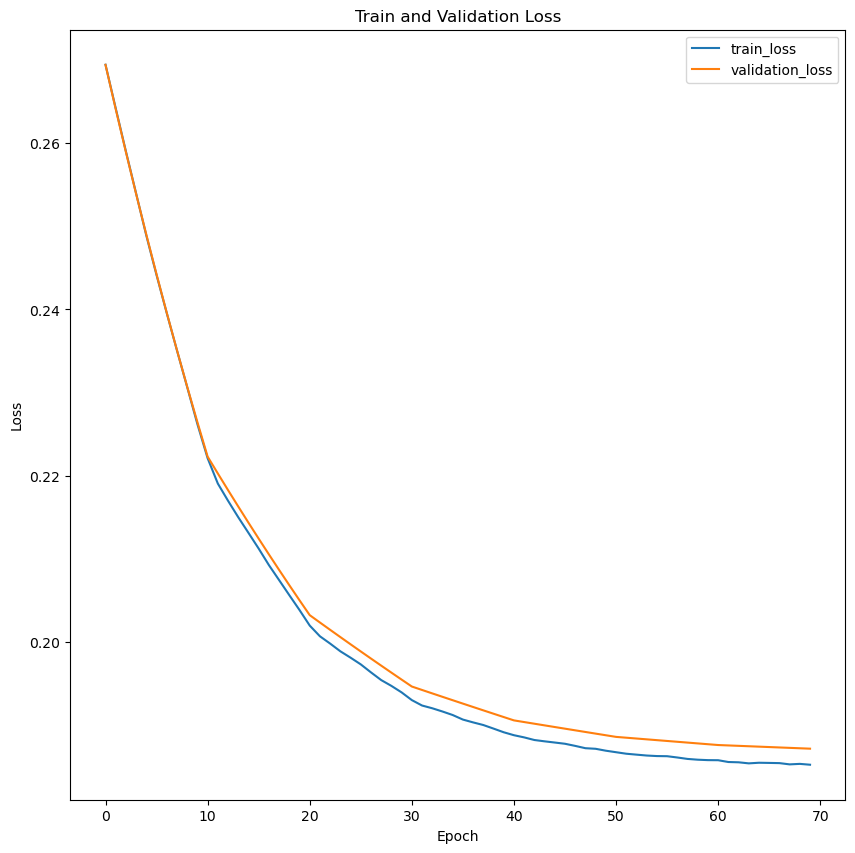

In [34]:
train_loss_array = np.array(train_loss_array)
validation_loss_array = np.array(validation_loss_array)

plt.figure(figsize=(10, 10))
plt.plot(range(len(train_loss_array)), train_loss_array, label='train_loss')
plt.plot(range(len(validation_loss_array)), validation_loss_array, label='validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

In [35]:
df = pd.DataFrame({'Train Loss': train_loss_array, 'Validation Loss': validation_loss_array, 'epoch': epoch_array, 'learning rate': lr_array, 'epoch_duration [s]': time_array})
df.head()

,Train Loss,Validation Loss,epoch,learning rate,epoch_duration [s]
0,0.269429,0.269416,0,0.001,81.824418
1,0.264188,0.264092,1,0.001,58.984767
2,0.258998,0.258913,2,0.001,140.846682
3,0.253937,0.253877,3,0.001,58.898223
4,0.248870,0.248981,4,0.001,56.731372


In [36]:
df

,Train Loss,Validation Loss,epoch,learning rate,epoch_duration [s]
0,0.269429,0.269416,0,0.001000,81.824418
1,0.264188,0.264092,1,0.001000,58.984767
2,0.258998,0.258913,2,0.001000,140.846682
3,0.253937,0.253877,3,0.001000,58.898223
4,0.248870,0.248981,4,0.001000,56.731372
...,...,...,...,...,...
65,0.185450,0.187359,65,0.000016,63.480760
66,0.185427,0.187310,66,0.000016,64.421196
67,0.185275,0.187261,67,0.000016,77.494914
68,0.185335,0.187213,68,0.000016,74.728611


# Tesntando o modelo em uma imagem

C:\Users\Pedro\AppData\Local\Temp\ipykernel_10228\1583506645.py:5: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use BILINEAR or Resampling.BILINEAR instead.
  transforms.Resize((128, 128), interpolation=Image.LINEAR),
C:\Users\Pedro\AppData\Local\Temp\ipykernel_10228\1583506645.py:7: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use BILINEAR or Resampling.BILINEAR instead.
  transforms.Resize((256, 256), interpolation=Image.LINEAR)
C:\Users\Pedro\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI

torch.Size([3, 256, 256])
246


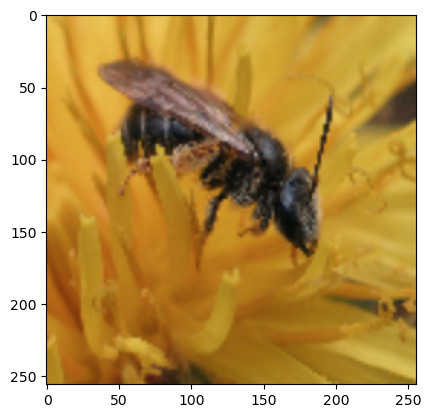

In [38]:
new_image = Image.open(f"{DATASET_ROOT}/Flickr2K/000797.png")
transform = transforms.Compose([
    transforms.ToTensor(),
    # resize image to 33x33 and downsample by BICUBIC interpolation
    transforms.Resize((128, 128), interpolation=Image.LINEAR),
    # resize image to 256x256
    transforms.Resize((256, 256), interpolation=Image.LINEAR)
])


new_image_lr = transform(new_image)
print(new_image_lr.shape)
print(np.array(new_image).max())
image_helper.show_tensor_as_image(new_image_lr) # mudar pro arquivo novo


In [39]:
import matplotlib.pyplot as plt

plt.figure()
new_image_sr_np = new_image_sr.cpu().detach().numpy()
new_img = torch.mul(new_image_sr, 3)
plt.imshow(new_image_sr_np.transpose((1, 2, 0)))
plt.show()

NameError: name 'new_image_sr' is not defined

<Figure size 640x480 with 0 Axes>